In [14]:

import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cpu


In [15]:
## Paramaters
steps=50000
lr=1e-3
total_points=500
min=1
max=3
a_true = 2

Nu=2
Nf=250
layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers

def f_BC(t):
 return torch.exp(a_true *t)

In [17]:
# Parameters for equation

def grad(function,var):
    return autograd.grad(function, var, grad_outputs=torch.ones_like(function), create_graph=True)[0]



class PINN(nn.Module):

    def __init__(self):
        super(PINN, self).__init__()

        

        # self.input = nn.Linear(1, 20)
        # self.hidden = nn.Linear(20, 20)
        # self.out = nn.Linear(20, 1)

        self.activation = nn.Tanh()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0

        # training

    def forward(self, x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        layer = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](layer)              
            layer = self.activation(z)    
        layer = self.linears[-1](layer)
        return layer
        # if torch.is_tensor(x) != True:         
        #     x = torch.from_numpy(x)                
        # a = x.float()
        # x = self.hidden(x)
        # x = self.activation(x)

        # x = self.hidden(x)
        # x = self.activation(x)


        # x = self.out(x)
        # return x

    # We are using a simple exponential equation to test the PINN

    def LossBC(self,x_BC):
        loss_bc = torch.mean((self.forward(x_BC) - f_BC(x_BC))**2)
        return loss_bc

    def LossPDE(self,t):

        temp = t.clone()
        temp.requires_grad = True

        u = self.forward(temp)
        u_t = autograd.grad(u,temp,grad_outputs=torch.ones_like(u),create_graph=True)[0]
        # u_t = grad(u,t)

        eq1 = u_t - a_true*u
        # print("eq1 data type: ",type(eq1))
        loss_PDE = torch.mean(eq1**2)
        return loss_PDE
        
    def LossComb(self,t,x_BC):
        loss_bc = self.LossBC(x_BC)
        loss_pde = self.LossPDE(t)

        # print("bc data type: ",type(loss_bc))
        # print("pde data type: ",type(loss_pde))
        
        return loss_bc + loss_pde

    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.Loss_Comb(x_train, y_train)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:
        
            print(loss)

        return loss   
     

pinn = PINN()

In [18]:
## Generate the data
x = torch.linspace(min,max,total_points).view(-1,1) #prepare to NN
y = f_BC(x)
print(x.shape, y.shape)


torch.Size([500, 1]) torch.Size([500, 1])


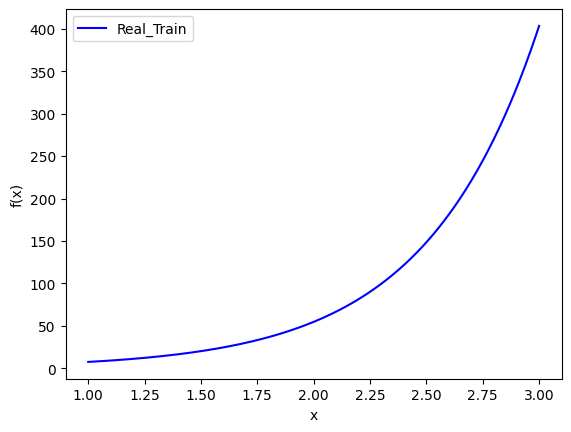

In [19]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
#ax1.plot(x_train.detach().numpy(),yh.detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

In [20]:
#def get_training_data(x):
#Nu: Number of training point, # Nf: Number of colloction points
# Set Boundary conditions:
BC_1=x[0,:]
BC_2=x[-1,:]
# Total Training points BC1+BC2
all_train=torch.vstack([BC_1,BC_2])
#Select Nu points
idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC=all_train[idx]
#Select Nf points
# Latin Hypercube sampling for collocation points 
x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)
x_PDE = torch.vstack((x_PDE,x_BC)) 

x_PDE.shape

C:\Users\anton\AppData\Local\Temp\ipykernel_27096\601207811.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)


torch.Size([252, 1])

In [12]:
#Store tensors to GPU
torch.manual_seed(123)
x_PDE=x_PDE.float().to(device)
x_BC=x_BC.to(device)
#Create Model
model = PINN()
print(model)
model.to(device)
params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
start_time = time.time()

PINN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [13]:
for i in range(steps):
    yh = model(x_PDE)
    loss = model.LossComb(x_PDE,x_BC)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(loss)

tensor(81472.1094, grad_fn=<AddBackward0>)
tensor(13930.5908, grad_fn=<AddBackward0>)
tensor(97.2485, grad_fn=<AddBackward0>)
tensor(0.0918, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [142]:
yh=model(x.to(device))
y=f_BC(x)
#Error
print(model.LossBC(x.to(device)))

tensor(0.0590, grad_fn=<MeanBackward0>)


In [143]:
# Derivative
g=x.to(device)
g=g.clone()
g.requires_grad=True #Enable differentiation
f=model(g)
f_x=autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]

In [144]:
y_plot=y.detach().numpy()
yh_plot=yh.detach().cpu().numpy()
f_x_plot=f_x.detach().cpu().numpy()


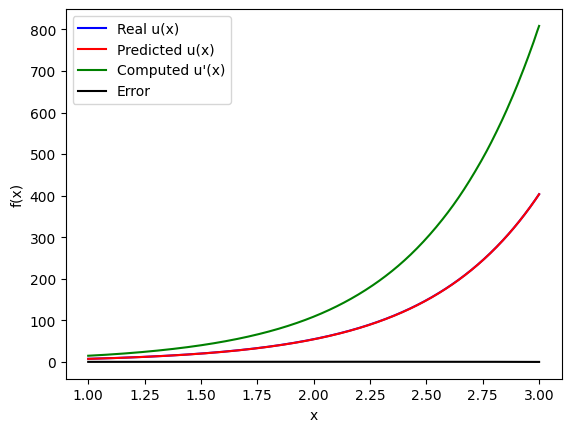

In [148]:
# Plot
fig, ax1 = plt.subplots()
ax1.plot(x,y_plot,color='blue',label='Real u(x)')
ax1.plot(x,yh_plot,color='red',label='Predicted u(x)')
ax1.plot(x,f_x_plot,color='green',label='Computed u\'(x)')
ax1.plot(x,y_plot-yh_plot,color='black',label='Error')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')
